# Setup


In [ ]:
!pip install tensorflow==2.15.0
!pip install tensorflow-recommenders --no-deps

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 28.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 37.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 442.0/442.0 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.7 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.16.0
    Uninstalling wrapt-1.16.0:
      Successfully uninstalled wrapt-1.16.0
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.4.1
    Uninstalling ml-dtypes-0.4.1:
      Successfully uninstalled ml-dtypes-0.4.1
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
  Attempting uninstall: tensorboard
    Found existing installation

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_recommenders as tfrs
import keras

import json
from google.colab import drive
from collections import Counter

import tempfile
import os

import matplotlib.pyplot as plt

# Load Dataset

In [ ]:
places_data = pd.read_csv('https://raw.githubusercontent.com/Voyageur-Team/Machine-Learning/refs/heads/main/dataset/places_dataset.csv')
places_data.sample(5)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Link,Address
747,830,Taman Tugu Pahlawan,Taman Tugu Pahlawan,Alam,Surabaya,0,48,https://www.google.com/maps/place/Taman+Tugu+P...,"QP3Q+F4G, Jl. Pangeran Limboro, Alun-alun Cont..."
1115,1278,Nusa Penida,Penida Island,Alam,Bali,0,46,https://www.google.com/maps/place/Nusa+penida/...,"Penida Island, Nusa Penida, Klungkung Regency,..."
166,167,Geoforest Watu Payung Turunan,Bagi para pemburu keindahan matahari terbit ya...,Alam,Yogyakarta,0,45,https://www.google.com/maps/place/Geoforest+Wa...,NaN
97,98,Taman Pelangi Yogyakarta,Taman Pelangi Yogyakarta merupakan tempat wisa...,Taman Hiburan,Yogyakarta,15000,43,https://www.google.com/maps/place/Taman+Pelang...,NaN
133,134,Desa Wisata Gamplong,Desa Wisata Gamplong adalah desa wisata keraji...,Budaya,Yogyakarta,10000,44,https://www.google.com/maps/place/Desa+wisata+...,NaN


In [ ]:
ratings_data = pd.read_csv('https://raw.githubusercontent.com/Voyageur-Team/Machine-Learning/refs/heads/main/dataset/place_ratings.csv')
ratings_data = ratings_data.loc[:, ~ratings_data.columns.str.contains('^Unnamed')]
ratings_data.sample(3)

,User_Id,Place_Id,Place_Ratings
22279,10894,874,5.0
6193,186,265,4.0
4668,142,349,2.0


In [ ]:
all_data = pd.merge(ratings_data, places_data, on='Place_Id', how='left')
all_data

,User_Id,Place_Id,Place_Ratings,Place_Name,Description,Category,City,Price,Rating,Link,Address
0,1,179,3.0,Candi Ratu Boko,Situs Ratu Baka atau Candi Boko (Hanacaraka:ꦕꦤ...,Budaya,Yogyakarta,75000.0,46.0,https://www.google.com/maps/place/Keraton+Ratu...,NaN
1,1,344,2.0,Pantai Marina,"Pantai Marina (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ꦩꦫꦶꦤ, trans...",Pantai,Semarang,3000.0,41.0,https://www.google.com/maps/place/Pantai+Marin...,NaN
2,1,5,5.0,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Wahana Air,Jakarta,94000.0,45.0,https://www.google.com/maps/place/Atlantis+Wat...,NaN
3,1,373,3.0,Museum Kereta Ambarawa,Museum Kereta Api Ambarawa (bahasa Inggris: In...,Budaya,Semarang,10000.0,45.0,https://www.google.com/maps/place/Museum+Keret...,NaN
4,1,101,4.0,Kampung Wisata Sosro Menduran,Kampung wisata Sosromenduran merupakan kampung...,Taman Hiburan,Yogyakarta,0.0,40.0,https://www.google.com/maps/place/Kampung+Wisa...,NaN
...,...,...,...,...,...,...,...,...,...,...,...
26372,13173,1015,5.0,Pos Ketan Legenda - 1967,Pos Ketan Legenda - 1967,Lainnya,Malang,20000.0,45.0,https://www.google.com/maps/place/Pos+Ketan+Le...,"Jl. Kartini No.6, Ngaglik, Sisir, Kec. Batu, M..."
26373,14132,1015,5.0,Pos Ketan Legenda - 1967,Pos Ketan Legenda - 1967,Lainnya,Malang,20000.0,45.0,https://www.google.com/maps/place/Pos+Ketan+Le...,"Jl. Kartini No.6, Ngaglik, Sisir, Kec. Batu, M..."
26374,14133,1015,3.0,Pos Ketan Legenda - 1967,Pos Ketan Legenda - 1967,Lainnya,Malang,20000.0,45.0,https://www.google.com/maps/place/Pos+Ketan+Le...,"Jl. Kartini No.6, Ngaglik, Sisir, Kec. Batu, M..."
26375,14134,1015,3.0,Pos Ketan Legenda - 1967,Pos Ketan Legenda - 1967,Lainnya,Malang,20000.0,45.0,https://www.google.com/maps/place/Pos+Ketan+Le...,"Jl. Kartini No.6, Ngaglik, Sisir, Kec. Batu, M..."


In [ ]:
def categorize_price(price):
  if 0 <= price < 25000:
    return '0-25'
  elif 25000 <= price < 50000:
    return '25-50'
  elif 50000 <= price < 100000:
    return '50-100'
  elif 100000 <= price < 200000:
    return '100-200'
  elif price >= 200000:
    return '200+'
  else:
    return 'Unknown'

all_data['Price_Category'] = all_data['Price'].apply(categorize_price)
all_data[['Price',"Price_Category"]]

,Price,Price_Category
0,75000.0,50-100
1,3000.0,0-25
2,94000.0,50-100
3,10000.0,0-25
4,0.0,0-25
...,...,...
26372,20000.0,0-25
26373,20000.0,0-25
26374,20000.0,0-25
26375,20000.0,0-25


##convert to tensorflow

In [ ]:
places_data['Description'] = places_data['Description'].astype(str)
places_data['Category'] = places_data['Category'].astype(str)
places_data['City'] = places_data['City'].astype(str)

places_data_tf = tf.data.Dataset.from_tensor_slices({
    'Place_Id': tf.cast(places_data['Place_Id'].values, dtype=tf.int64),  # String column for place names
    'Place_Name': tf.convert_to_tensor(places_data['Place_Name'].values, dtype=tf.string),    # String column for links
    'Description': tf.convert_to_tensor(places_data['Description'].values, dtype=tf.string),
    'Category': tf.convert_to_tensor(places_data['Category'].values, dtype=tf.string),  # City as string
    'City': tf.convert_to_tensor(places_data['City'].values, dtype=tf.string),  # Category as string
    'Price': tf.cast(places_data['Price'].values, dtype=tf.float64),  # Fee as float
    'Rating': tf.cast(places_data['Rating'].values, dtype=tf.float64),  # Address as string
})

places_data_tf

<_TensorSliceDataset element_spec={'Place_Id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Place_Name': TensorSpec(shape=(), dtype=tf.string, name=None), 'Description': TensorSpec(shape=(), dtype=tf.string, name=None), 'Category': TensorSpec(shape=(), dtype=tf.string, name=None), 'City': TensorSpec(shape=(), dtype=tf.string, name=None), 'Price': TensorSpec(shape=(), dtype=tf.float64, name=None), 'Rating': TensorSpec(shape=(), dtype=tf.float64, name=None)}>

In [ ]:
all_data['Place_Name'] = all_data['Place_Name'].astype(str)
all_data['Description'] = all_data['Description'].astype(str)
all_data['Category'] = all_data['Category'].astype(str)
all_data['City'] = all_data['City'].astype(str)
all_data['Price_Category'] = all_data['Price_Category'].astype(str)

ratings_data_tf = tf.data.Dataset.from_tensor_slices({
    'User_Id': tf.cast(all_data['User_Id'].values, dtype=tf.int64),
    'Place_Id': tf.cast(all_data['Place_Id'].values, dtype=tf.int64),  # String column for place names
    'Place_Name': tf.convert_to_tensor(all_data['Place_Name'].values, dtype=tf.string),    # String column for links
    'Description': tf.convert_to_tensor(all_data['Description'].values, dtype=tf.string),
    'Category': tf.convert_to_tensor(all_data['Category'].values, dtype=tf.string),  # City as string
    'City': tf.convert_to_tensor(all_data['City'].values, dtype=tf.string),  # Category as string
    'Price': tf.cast(all_data['Price'].values, dtype=tf.float64),  # Fee as float
    'Price_Category': tf.convert_to_tensor(all_data['Price_Category'].values, dtype=tf.string),  # Category as string
    'Place_Ratings': tf.cast(all_data['Place_Ratings'].values, dtype=tf.float64),  # Address as string
})

ratings_data_tf

<_TensorSliceDataset element_spec={'User_Id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Place_Id': TensorSpec(shape=(), dtype=tf.int64, name=None), 'Place_Name': TensorSpec(shape=(), dtype=tf.string, name=None), 'Description': TensorSpec(shape=(), dtype=tf.string, name=None), 'Category': TensorSpec(shape=(), dtype=tf.string, name=None), 'City': TensorSpec(shape=(), dtype=tf.string, name=None), 'Price': TensorSpec(shape=(), dtype=tf.float64, name=None), 'Price_Category': TensorSpec(shape=(), dtype=tf.string, name=None), 'Place_Ratings': TensorSpec(shape=(), dtype=tf.float64, name=None)}>

In [ ]:
ratings = ratings_data_tf.map(lambda x: {
    "Place_Name": x["Place_Name"],
    'City': x['City'],
    'Category': x['Category'],
    'Price_Category': x['Price_Category']
})

places = places_data_tf.map(lambda x: x["Place_Name"])

In [ ]:
city_unique = np.unique(np.concatenate(list(ratings.batch(64).map(lambda x: x["City"]))))
category_unique = np.unique(np.concatenate(list(ratings.batch(64).map(lambda x: x["Category"]))))
price_unique = np.unique(np.concatenate(list(ratings.batch(64).map(lambda x: x["Price_Category"]))))
place_name_unique = np.unique(np.concatenate(list(places.batch(64))))
print('city_unique:', city_unique, len(city_unique))
print('category_unique:', category_unique, len(category_unique))
print('price_unique:', price_unique, len(price_unique))
print('place_name_unique:', place_name_unique, len(place_name_unique))

city_unique: [b'Bali' b'Bandung' b'Bogor' b'Jakarta' b'Lombok' b'Malang' b'Manado'
 b'Raja Ampat' b'Semarang' b'Solo' b'Surabaya' b'Yogyakarta' b'nan'] 13
category_unique: [b'Alam' b'Bahari' b'Belanja' b'Budaya' b'Edukasi' b'Gunung' b'Healing'
 b'Kebun Binatang' b'Klub' b'Kuliner' b'Lainnya' b'Pantai'
 b'Pusat Perbelanjaan' b'Religi' b'Sejarah' b'Spot Foto' b'Taman'
 b'Taman Hiburan' b'Taman Kota' b'Wahana' b'Wahana Air' b'Wahana Alam'
 b'Wahana Bermain' b'Wahana Ekstrem' b'Wisata Bermain' b'Wisata Rekreasi'
 b'nan' b'pantai'] 28
price_unique: [b'0-25' b'100-200' b'200+' b'25-50' b'50-100' b'Unknown'] 6
place_name_unique: [b'(WBF) Wisata Bukit Flora | Agrowisata, Outbound, Edukasi, Anak'
 b'A Fung' b'Abyss Zipline' ... b'Wonosari Tea Plantation' b'Wot Batu'
 b'Yeh Gangga Klub'] 1220


# Model

## Model Architecture

In [ ]:
class UserModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    self.city_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=city_unique, mask_token=None),
        tf.keras.layers.Embedding(len(city_unique) + 1, 32),
    ])

    self.category_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=category_unique, mask_token=None),
        tf.keras.layers.Embedding(len(category_unique) + 1, 32),
    ])

    self.price_embedding = tf.keras.Sequential([
        tf.keras.layers.StringLookup(
            vocabulary=price_unique, mask_token=None),
        tf.keras.layers.Embedding(len(price_unique) + 1, 32),
    ])

  def call(self, inputs):
    return tf.concat([
        self.city_embedding(inputs["City"]),
        self.category_embedding(inputs["Category"]),
        self.price_embedding(inputs["Price_Category"]),
    ], axis=1)

  def get_config(self):
    base_config = super().get_config()
    config = {
        'city_embedding': self.city_embedding.get_config(),
        'category_embedding': self.category_embedding.get_config(),
        'price_embedding': self.price_embedding.get_config(),
    }
    return config

  @classmethod
  def from_config(cls, config):
    model = cls()
    model.city_embedding = tf.keras.Sequential.from_config(config['city_embedding'])
    model.category_embedding = tf.keras.Sequential.from_config(config['category_embedding'])
    model.price_embedding = tf.keras.Sequential.from_config(config['price_embedding'])
    return model

In [ ]:
class QueryModel(tf.keras.Model):

  def __init__(self, layer_sizes):
    super().__init__()

    self.user_embedding_model = UserModel()

    self.dense_layers = tf.keras.Sequential()

    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.user_embedding_model(inputs)
    return self.dense_layers(feature_embedding)

  def get_config(self):
    base_config = super().get_config()
    config = {
        'user_embedding_model': self.user_embedding_model.get_config(),
        'dense_layers': self.dense_layers.get_config(),
    }
    return config

  @classmethod
  def from_config(cls, config):
      model = cls()
      model.user_embedding_model = UserModel.from_config(config['user_embedding_model'])
      model.dense_layers = tf.keras.Sequential.from_config(config['dense_layers'])
      return model

In [ ]:
class PlaceModel(tf.keras.Model):

  def __init__(self):
    super().__init__()

    max_tokens = 10000

    self.place_embedding = tf.keras.Sequential([
      tf.keras.layers.StringLookup(
          vocabulary=place_name_unique,mask_token=None),
      tf.keras.layers.Embedding(len(place_name_unique) + 1, 32)
    ])

    self.place_vectorizer = tf.keras.layers.TextVectorization(
        max_tokens=max_tokens)

    self.place_text_embedding = tf.keras.Sequential([
      self.place_vectorizer,
      tf.keras.layers.Embedding(max_tokens, 32, mask_zero=True),
      tf.keras.layers.GlobalAveragePooling1D(),
    ])

    self.place_vectorizer.adapt(places)

  def call(self, place):
    return tf.concat([
        self.place_embedding(place),
        self.place_text_embedding(place),
    ], axis=1)

  def get_config(self):
    base_config = super().get_config()
    config = {
        'place_embedding': self.place_embedding.get_config(),
        'place_text_embedding': self.place_text_embedding.get_config(),
    }
    return config

  @classmethod
  def from_config(cls, config):
    model = cls()
    model.place_embedding = tf.keras.Sequential.from_config(config['place_embedding'])
    model.place_text_embedding = tf.keras.Sequential.from_config(config['place_text_embedding'])
    return model

In [ ]:
class CandidateModel(tf.keras.Model):

  def __init__(self, layer_sizes):
    super().__init__()

    self.place_embedding_model = PlaceModel()

    self.dense_layers = tf.keras.Sequential()

    for layer_size in layer_sizes[:-1]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size, activation="relu"))

    for layer_size in layer_sizes[-1:]:
      self.dense_layers.add(tf.keras.layers.Dense(layer_size))

  def call(self, inputs):
    feature_embedding = self.place_embedding_model(inputs)
    return self.dense_layers(feature_embedding)

  def get_config(self):
    base_config = super().get_config()
    config = {
        'place_embedding_model': self.place_embedding_model.get_config(),
        'dense_layers': self.dense_layers.get_config(),
    }
    return config

  @classmethod
  def from_config(cls, config):
      model = cls()
      model.place_embedding_model = PlaceModel.from_config(config['place_embedding_model'])
      model.dense_layers = tf.keras.Sequential.from_config(config['dense_layers'])
      return model

In [ ]:
class PlaceDestinationModel(tfrs.models.Model):

  def __init__(self, layer_sizes):
    super().__init__()
    self.query_model = QueryModel(layer_sizes)
    self.candidate_model = CandidateModel(layer_sizes)
    self.task = tfrs.tasks.Retrieval(
        metrics=tfrs.metrics.FactorizedTopK(
            candidates=places.batch(128).map(self.candidate_model),
        ),
    )

  def compute_loss(self, features, training=False):

    query_embeddings = self.query_model({
        "City": features["City"],
        "Category": features["Category"],
        "Price_Category": features["Price_Category"],
    })
    place_embeddings = self.candidate_model(features["Place_Name"])

    return self.task(
        query_embeddings, place_embeddings, compute_metrics=not training)

  def get_config(self):
      base_config = super().get_config()
      config = {
          'candidate_model': self.candidate_model.get_config(),
          'query_model': self.query_model.get_config(),
      }
      return config

  @classmethod
  def from_config(cls, config):
      model = cls(layer_sizes=[64])  # Ensure you pass the correct layer sizes
      model.candidate_model = CandidateModel.from_config(config['candidate_model'])
      model.query_model = QueryModel.from_config(config['query_model'])
      return model


## Training

In [ ]:
tf.random.set_seed(42)
shuffled = ratings.shuffle(len(ratings), seed=42, reshuffle_each_iteration=False)

train = shuffled.take(int(0.8 * len(ratings)))
test = shuffled.skip(int(0.8 * len(ratings))).take(int(0.2 * len(ratings)))

cached_train = train.shuffle(len(ratings)).batch(256)
cached_test = test.batch(512).cache()

In [ ]:
num_epochs = 100

In [ ]:
model1 = PlaceDestinationModel([16])
model1.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model1_history = model1.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = model1_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

model1.evaluate(cached_test, return_dict=True)

Top-100 accuracy: 1.00.
11/11 [==============================] - 2s 166ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1678 - factorized_top_k/top_5_categorical_accuracy: 0.5454 - factorized_top_k/top_10_categorical_accuracy: 0.7156 - factorized_top_k/top_50_categorical_accuracy: 0.9587 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 749.4102 - regularization_loss: 0.0000e+00 - total_loss: 749.4102


{'factorized_top_k/top_1_categorical_accuracy': 0.16777251660823822,
 'factorized_top_k/top_5_categorical_accuracy': 0.5454028248786926,
 'factorized_top_k/top_10_categorical_accuracy': 0.7156398296356201,
 'factorized_top_k/top_50_categorical_accuracy': 0.9586730003356934,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 151.43638610839844,
 'regularization_loss': 0,
 'total_loss': 151.43638610839844}

In [ ]:
model2 = PlaceDestinationModel([32])
model2.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model2_history = model2.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = model2_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

model2.evaluate(cached_test, return_dict=True)

Top-100 accuracy: 1.00.
11/11 [==============================] - 2s 163ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1691 - factorized_top_k/top_5_categorical_accuracy: 0.5475 - factorized_top_k/top_10_categorical_accuracy: 0.7109 - factorized_top_k/top_50_categorical_accuracy: 0.9566 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 749.0974 - regularization_loss: 0.0000e+00 - total_loss: 749.0974


{'factorized_top_k/top_1_categorical_accuracy': 0.16909952461719513,
 'factorized_top_k/top_5_categorical_accuracy': 0.5474881529808044,
 'factorized_top_k/top_10_categorical_accuracy': 0.7109004855155945,
 'factorized_top_k/top_50_categorical_accuracy': 0.9565876722335815,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 151.37216186523438,
 'regularization_loss': 0,
 'total_loss': 151.37216186523438}

In [ ]:
model3 = PlaceDestinationModel([64])
model3.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model3_history = model3.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = model3_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

model3.evaluate(cached_test, return_dict=True)

Top-100 accuracy: 1.00.
11/11 [==============================] - 3s 264ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1454 - factorized_top_k/top_5_categorical_accuracy: 0.5369 - factorized_top_k/top_10_categorical_accuracy: 0.7065 - factorized_top_k/top_50_categorical_accuracy: 0.9581 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 749.6331 - regularization_loss: 0.0000e+00 - total_loss: 749.6331


{'factorized_top_k/top_1_categorical_accuracy': 0.14540284872055054,
 'factorized_top_k/top_5_categorical_accuracy': 0.5368720293045044,
 'factorized_top_k/top_10_categorical_accuracy': 0.7065402865409851,
 'factorized_top_k/top_50_categorical_accuracy': 0.9581042528152466,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 151.56948852539062,
 'regularization_loss': 0,
 'total_loss': 151.56948852539062}

In [ ]:
model4 = PlaceDestinationModel([64, 32])
model4.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model4_history = model4.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = model4_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

model4.evaluate(cached_test, return_dict=True)

Top-100 accuracy: 1.00.
11/11 [==============================] - 2s 170ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1386 - factorized_top_k/top_5_categorical_accuracy: 0.5291 - factorized_top_k/top_10_categorical_accuracy: 0.7012 - factorized_top_k/top_50_categorical_accuracy: 0.9575 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 748.3363 - regularization_loss: 0.0000e+00 - total_loss: 748.3363


{'factorized_top_k/top_1_categorical_accuracy': 0.13857820630073547,
 'factorized_top_k/top_5_categorical_accuracy': 0.5290995240211487,
 'factorized_top_k/top_10_categorical_accuracy': 0.7012322545051575,
 'factorized_top_k/top_50_categorical_accuracy': 0.9575355648994446,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 151.300048828125,
 'regularization_loss': 0,
 'total_loss': 151.300048828125}

In [ ]:
model5 = PlaceDestinationModel([128, 64, 32])
model5.compile(optimizer=tf.keras.optimizers.Adagrad(0.1))

model5_history = model5.fit(
    cached_train,
    validation_data=cached_test,
    validation_freq=5,
    epochs=num_epochs,
    verbose=0)

accuracy = model5_history.history["val_factorized_top_k/top_100_categorical_accuracy"][-1]
print(f"Top-100 accuracy: {accuracy:.2f}.")

model5.evaluate(cached_test, return_dict=True)

Top-100 accuracy: 1.00.
11/11 [==============================] - 2s 184ms/step - factorized_top_k/top_1_categorical_accuracy: 0.1433 - factorized_top_k/top_5_categorical_accuracy: 0.5266 - factorized_top_k/top_10_categorical_accuracy: 0.7098 - factorized_top_k/top_50_categorical_accuracy: 0.9539 - factorized_top_k/top_100_categorical_accuracy: 1.0000 - loss: 749.3046 - regularization_loss: 0.0000e+00 - total_loss: 749.3046


{'factorized_top_k/top_1_categorical_accuracy': 0.14331753551959991,
 'factorized_top_k/top_5_categorical_accuracy': 0.5266350507736206,
 'factorized_top_k/top_10_categorical_accuracy': 0.7097630500793457,
 'factorized_top_k/top_50_categorical_accuracy': 0.9539336562156677,
 'factorized_top_k/top_100_categorical_accuracy': 1.0,
 'loss': 151.3718719482422,
 'regularization_loss': 0,
 'total_loss': 151.3718719482422}

## Selection

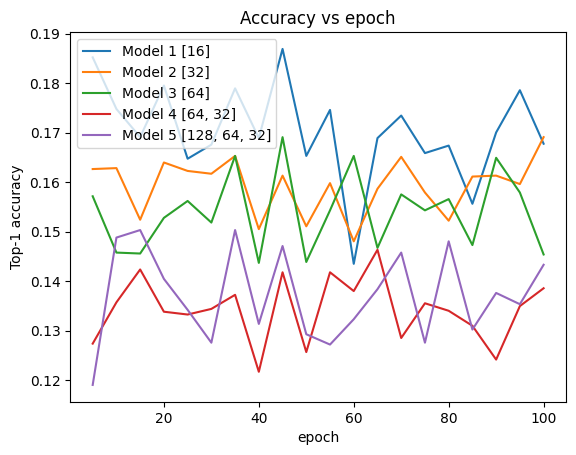

In [ ]:
# evaluation plot
num_validation_runs = len(model1_history.history["val_factorized_top_k/top_1_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, model1_history.history["val_factorized_top_k/top_1_categorical_accuracy"], label="Model 1 [16]")
plt.plot(epochs, model2_history.history["val_factorized_top_k/top_1_categorical_accuracy"], label="Model 2 [32]")
plt.plot(epochs, model3_history.history["val_factorized_top_k/top_1_categorical_accuracy"], label="Model 3 [64]")
plt.plot(epochs, model4_history.history["val_factorized_top_k/top_1_categorical_accuracy"], label="Model 4 [64, 32]")
plt.plot(epochs, model5_history.history["val_factorized_top_k/top_1_categorical_accuracy"], label="Model 5 [128, 64, 32]")

plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-1 accuracy");
plt.legend()

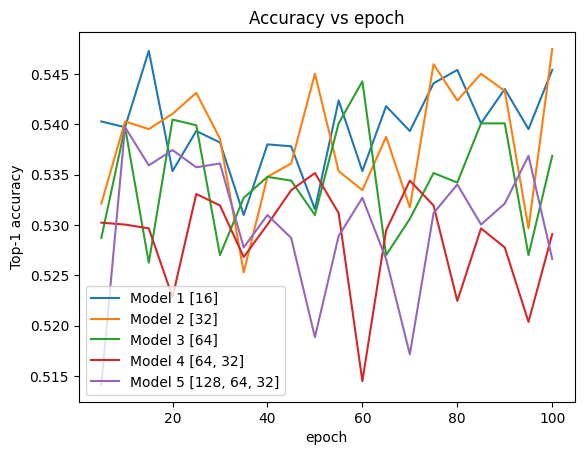

In [ ]:
# evaluation plot
num_validation_runs = len(model1_history.history["val_factorized_top_k/top_5_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, model1_history.history["val_factorized_top_k/top_5_categorical_accuracy"], label="Model 1 [16]")
plt.plot(epochs, model2_history.history["val_factorized_top_k/top_5_categorical_accuracy"], label="Model 2 [32]")
plt.plot(epochs, model3_history.history["val_factorized_top_k/top_5_categorical_accuracy"], label="Model 3 [64]")
plt.plot(epochs, model4_history.history["val_factorized_top_k/top_5_categorical_accuracy"], label="Model 4 [64, 32]")
plt.plot(epochs, model5_history.history["val_factorized_top_k/top_5_categorical_accuracy"], label="Model 5 [128, 64, 32]")

plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-1 accuracy");
plt.legend()

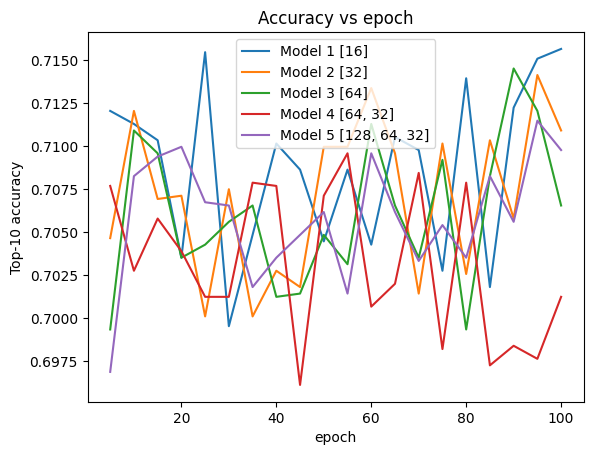

In [ ]:
import matplotlib.pyplot as plt
# evaluation plot
num_validation_runs = len(model1_history.history["val_factorized_top_k/top_10_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, model1_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label="Model 1 [16]")
plt.plot(epochs, model2_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label="Model 2 [32]")
plt.plot(epochs, model3_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label="Model 3 [64]")
plt.plot(epochs, model4_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label="Model 4 [64, 32]")
plt.plot(epochs, model5_history.history["val_factorized_top_k/top_10_categorical_accuracy"], label="Model 5 [128, 64, 32]")

plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-10 accuracy");
plt.legend()

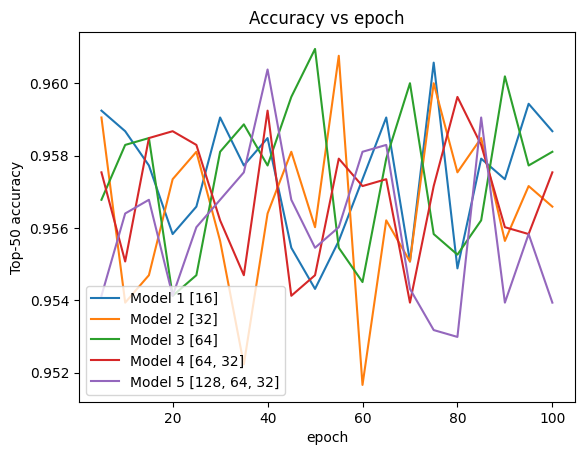

In [ ]:
import matplotlib.pyplot as plt
# evaluation plot
num_validation_runs = len(model1_history.history["val_factorized_top_k/top_50_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, model1_history.history["val_factorized_top_k/top_50_categorical_accuracy"], label="Model 1 [16]")
plt.plot(epochs, model2_history.history["val_factorized_top_k/top_50_categorical_accuracy"], label="Model 2 [32]")
plt.plot(epochs, model3_history.history["val_factorized_top_k/top_50_categorical_accuracy"], label="Model 3 [64]")
plt.plot(epochs, model4_history.history["val_factorized_top_k/top_50_categorical_accuracy"], label="Model 4 [64, 32]")
plt.plot(epochs, model5_history.history["val_factorized_top_k/top_50_categorical_accuracy"], label="Model 5 [128, 64, 32]")

plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-50 accuracy");
plt.legend()

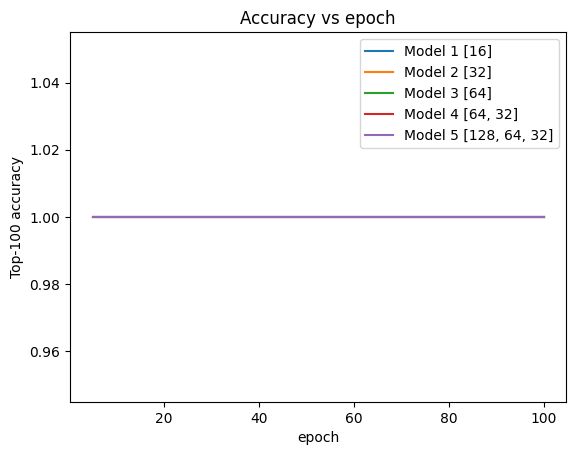

In [ ]:
import matplotlib.pyplot as plt
# evaluation plot
num_validation_runs = len(model1_history.history["val_factorized_top_k/top_100_categorical_accuracy"])
epochs = [(x + 1)* 5 for x in range(num_validation_runs)]

plt.plot(epochs, model1_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="Model 1 [16]")
plt.plot(epochs, model2_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="Model 2 [32]")
plt.plot(epochs, model3_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="Model 3 [64]")
plt.plot(epochs, model4_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="Model 4 [64, 32]")
plt.plot(epochs, model5_history.history["val_factorized_top_k/top_100_categorical_accuracy"], label="Model 5 [128, 64, 32]")

plt.title("Accuracy vs epoch")
plt.xlabel("epoch")
plt.ylabel("Top-100 accuracy");
plt.legend()

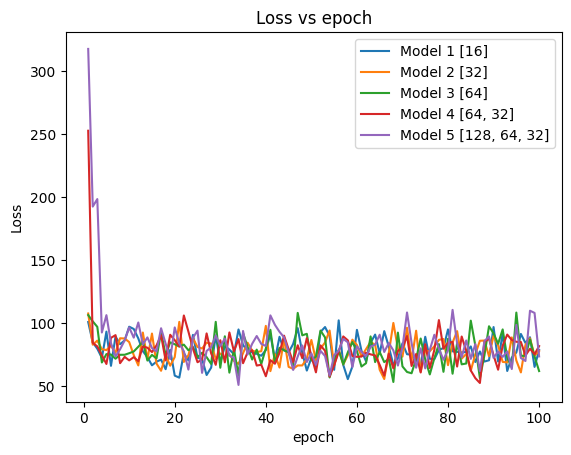

In [ ]:
import matplotlib.pyplot as plt
# evaluation plot
num_validation_runs = len(model1_history.history["loss"])
epochs = [(x + 1) for x in range(num_validation_runs)]

plt.plot(epochs, model1_history.history["loss"], label="Model 1 [16]")
plt.plot(epochs, model2_history.history["loss"], label="Model 2 [32]")
plt.plot(epochs, model3_history.history["loss"], label="Model 3 [64]")
plt.plot(epochs, model4_history.history["loss"], label="Model 4 [64, 32]")
plt.plot(epochs, model5_history.history["loss"], label="Model 5 [128, 64, 32]")

plt.title("Loss vs epoch")
plt.xlabel("epoch")
plt.ylabel("Loss");
plt.legend()

Based on model accuracy, loss, and time, we choose model number 2

In [ ]:
model = model2

## Model Predict

In [ ]:
index = tfrs.layers.factorized_top_k.BruteForce(model.query_model)
index.index_from_dataset(
tf.data.Dataset.zip((places.batch(128), places.batch(128).map(model.candidate_model)))
)
_, place = index({
    "City": np.array(['Semarang']),
    "Category": np.array(['Budaya']),
    "Price_Category": np.array(['0-25'])},
    k=10,
)
recommended_places = [place.decode('utf-8') for place in place.numpy()[0]]
recommended_places

['Tugu Muda Semarang',
 'Pura Giri Natha',
 'Kampung Tematik Jawi',
 'Pagoda Avalokitesvara',
 'Museum Kereta Ambarawa',
 'Kampung Batik',
 'Lawang Sewu',
 'Candi Gedong Songo',
 'Kampoeng Djadhoel Semarang',
 'Semarang Contemporary Art Gallery']

In [ ]:
model.query_model.predict({ "City": np.array(['Bandung']),
                            "Category": np.array(['Budaya']),
                            "Price_Category": np.array(['0-25'])})

1/1 [==============================] - 0s 122ms/step


array([[ 8.3466703e-01,  2.4889340e-01,  8.3183026e-01, -9.8317361e-01,
         1.6844568e+00, -1.7349774e-01, -5.8963484e-01,  2.5906041e-02,
        -3.9044133e-01, -2.9912475e-01,  1.5669847e+00,  6.9437021e-01,
         2.8641814e-01, -1.1826611e+00, -3.8368022e-01,  4.1363201e-01,
        -4.2342973e-01,  5.5677211e-01,  1.7657077e+00, -7.8304511e-01,
         7.7672720e-01, -1.5690892e+00, -1.3420024e+00, -7.5274938e-01,
        -2.4897476e-01, -1.9747265e-01,  1.7311119e-02,  4.3107235e-01,
         1.2791306e-03,  5.6552857e-01,  2.1363378e+00, -5.4908890e-01]],
      dtype=float32)

In [ ]:
model.candidate_model.predict(["Gedung Sate"])

1/1 [==============================] - 0s 160ms/step


array([[ 0.71614945,  0.06988391,  0.6736143 , -0.9869696 ,  1.4807838 ,
        -0.02171804,  0.0987286 , -0.05116782, -0.42972016,  0.04971248,
         1.270166  ,  1.0443491 ,  0.31524086, -1.3450336 , -0.59023577,
         0.2433444 , -0.3945888 ,  0.6142645 ,  1.4685526 , -0.0141262 ,
         0.47179148, -1.2827693 , -0.89443576, -0.6916369 , -0.5359041 ,
        -0.25615194,  0.24870682,  0.05123168, -0.6039477 ,  0.57210815,
         1.6032994 , -1.0803912 ]], dtype=float32)

## Save and Load Model

In [ ]:
model_dir = 'saved_model'

if not os.path.exists(model_dir):
  os.makedirs(model_dir)

path = os.path.join(model_dir, "model")

## Save Model

In [ ]:
tf.saved_model.save(index, path)

In [ ]:
model_json = model.to_json()
with open("saved_model/model.json", "w") as json_file:
    json.dump(model_json, json_file)

model.save_weights("saved_model/weights.tf", save_format='tf')

In [ ]:
import zipfile
import os

def zip_directory(folder_path, zip_path):
    with zipfile.ZipFile(zip_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, _, files in os.walk(folder_path):
            for file in files:
                zipf.write(os.path.join(root, file),
                           os.path.relpath(os.path.join(root, file),
                                           os.path.join(folder_path, '..')))

model_dir = 'saved_model'
zip_file_path = 'saved_model.zip'  # Specify the desired zip file path

zip_directory(model_dir, zip_file_path)

print(f"Model saved to {zip_file_path}")

Model saved to saved_model.zip


## Load Model

In [ ]:
loaded = tf.saved_model.load(path)
infer = loaded.signatures['serving_default']

In [ ]:
inputs = {
    "City": tf.constant(['Surabaya']),
    "Category": tf.constant(['Edukasi']),
    "Price_Category": tf.constant(['0-25'])
}

results = infer(**inputs)
place = results['output_2']
recommended_places = [place.decode('utf-8') for place in place.numpy()[0]]
recommended_places

['Taman Pintar Yogyakarta',
 'Alun - Alun Surabaya',
 'Kelenteng Sanggar Agung Kenjeran',
 'Jembatan Suroboyo',
 'Museum Radya Pustaka',
 'Surabaya Museum (Gedung Siola)',
 'Museum Sepuluh Nopember Kota Surabaya',
 'Museum Keris Nusantara',
 'Patung Dewi Kwan Im',
 'Taman Hiburan Rakyat']

# Itinerary Builder

## Grup Data Preference Analysis

In [ ]:
#user data dummy
user_data = pd.DataFrame([
    {
        "user_id": "U001",
        "name": "Ali",
        "preferred_destinations": ["Bali", "Lombok", "Yogyakarta"],
        "preferred_category": ["Pantai", "Budaya", "Kuliner"],
        "budget_range": [1000000, 3000000],
        "available_dates": ["2024-12-08", "2024-12-24"],
    },
    {
        "user_id": "U002",
        "name": "Siti",
        "preferred_destinations": ["Bandung", "Jakarta", "Surabaya"],
        "preferred_category": ["Kuliner", "Edukasi", "Taman"],
        "budget_range": [500000, 1500000],
        "available_dates": ["2024-12-10", "2024-12-20"],
    },
    {
        "user_id": "U003",
        "name": "Budi",
        "preferred_destinations": ["Malang", "Bali", "Yogyakarta"],
        "preferred_category": ["Alam", "Sejarah", "Gunung"],
        "budget_range": [2000000, 4000000],
        "available_dates": ["2024-12-15", "2024-12-25"],
    },
    {
        "user_id": "U004",
        "name": "Nurul",
        "preferred_destinations": ["Lombok", "Medan", "Padang"],
        "preferred_category": ["Pantai", "Kuliner", "Healing"],
        "budget_range": [1500000, 2500000],
        "available_dates": ["2024-12-12", "2024-12-30"],
    },
    {
        "user_id": "U005",
        "name": "Aisyah",
        "preferred_destinations": ["Jakarta", "Bandung", "Semarang"],
        "preferred_category": ["Edukasi", "Taman", "Kuliner"],
        "budget_range": [1000000, 2000000],
        "available_dates": ["2024-12-18", "2024-12-28"],
    },
    {
        "user_id": "U006",
        "name": "Farhan",
        "preferred_destinations": ["Bali", "Batam", "Makassar"],
        "preferred_category": ["Pantai", "Alam", "Healing"],
        "budget_range": [2500000, 5000000],
        "available_dates": ["2024-12-20", "2024-12-30"],
    },
    {
        "user_id": "U007",
        "name": "Dina",
        "preferred_destinations": ["Malang", "Bandung", "Medan"],
        "preferred_category": ["Budaya", "Sejarah", "Kuliner"],
        "budget_range": [1500000, 3000000],
        "available_dates": ["2024-12-10", "2024-12-25"],
    },
    {
        "user_id": "U008",
        "name": "Rezu",
        "preferred_destinations": ["Lombok", "Yogyakarta", "Semarang"],
        "preferred_category": ["Pantai", "Gunung", "Ekstrem"],
        "budget_range": [3000000, 6000000],
        "available_dates": ["2024-12-05", "2024-12-25"],
    },
    {
        "user_id": "U009",
        "name": "Nina",
        "preferred_destinations": ["Bandung", "Jakarta", "Surabaya"],
        "preferred_category": ["Anak", "Taman", "Edukasi"],
        "budget_range": [500000, 2000000],
        "available_dates": ["2024-12-10", "2024-12-30"],
    },
    {
        "user_id": "U010",
        "name": "Raka",
        "preferred_destinations": ["Medan", "Padang", "Makassar"],
        "preferred_category": ["Safari", "Kuliner", "Alam"],
        "budget_range": [2000000, 4000000],
        "available_dates": ["2024-12-15", "2024-12-31"],
    }
])

In [ ]:
group_data = {
    "group_id": "G001",
    "group_name": "Anti Wacana",
    "members": ["U001", "U002", "U003", "U004", "U005", "U006", "U007", "U008", "U009", "U0010"],
    "days_of_trip": 2
}

In [ ]:
def find_common_destination(user_data):
# Find the most common destination
    all_destinations = []
    for destinations in user_data['preferred_destinations']:
        all_destinations.extend(destinations)
    common_destination = pd.Series(all_destinations).mode()[0]
    return common_destination

In [ ]:
def find_common_categories(user_data):
  # Find the top 3 most common categories
    all_categories = []
    for categories in user_data['preferred_category']:
        all_categories.extend(categories)
    common_categories = pd.Series(all_categories).value_counts().head(3).index.tolist()
    return common_categories

In [ ]:
def find_budget_average(user_data):
  # Calculate the average budget range
    min_budgets = user_data['budget_range'].apply(lambda x: x[0])
    max_budgets = user_data['budget_range'].apply(lambda x: x[1])
    intermediate_budget = (min_budgets.mean() + max_budgets.mean()) / 2
    return intermediate_budget

In [ ]:
def find_common_dates(user_data):
    # Find most avaiable date
    all_dates = []
    for dates in user_data['available_dates']:
        all_dates.extend(dates)
    date_counts = Counter(all_dates)
    max_count = max(date_counts.values())
    most_common_dates = [date for date, count in date_counts.items() if count == max_count]

    # if no avaiable dates
    if not most_common_dates:
        most_common_dates = ['No available dates']

    if most_common_dates != ['No available dates']:
        sorted_dates = sorted(most_common_dates)
        trip_start_date = sorted_dates[0]
        # Calculate the trip's end date (3 days after the start)
        trip_end_date = pd.to_datetime(trip_start_date) + pd.Timedelta(days=group_data["days_of_trip"] - 1)
        trip_end_date = trip_end_date.strftime('%Y-%m-%d')

    else:
        trip_start_date = "No available dates"
        trip_end_date = "No available dates"

    return most_common_dates, trip_start_date, trip_end_date

Common available dates: set()


In [ ]:
def destination_budget_threshold(group_data):
  num_destinations = group_data['days_of_trip'] * 4
  #assuming moving cost / destination
  moving_cost = 50000
  threshold = (group_data['average_budget_range'] - (moving_cost * num_destinations)) / num_destinations
  return threshold

In [ ]:
group_data['most_common_destination'] = find_common_destination(user_data)
group_data['most_common_categories'] = find_common_categories(user_data)
group_data['average_budget_range'] = find_budget_average(user_data)
group_data['most_available_dates'], group_data['trip_start_date'], group_data['trip_end_date'] = find_common_dates(user_data)
group_data['destination_budget_threshold'] = destination_budget_threshold(group_data)
group_data

{'group_id': 'G001',
 'group_name': 'Anti Wacana',
 'members': ['U001',
  'U002',
  'U003',
  'U004',
  'U005',
  'U006',
  'U007',
  'U008',
  'U009',
  'U0010'],
 'days_of_trip': 2,
 'most_common_destination': 'Bandung',
 'most_common_categories': ['Kuliner', 'Pantai', 'Edukasi'],
 'average_budget_range': 2425000.0,
 'most_available_dates': ['2024-12-10', '2024-12-25', '2024-12-30'],
 'trip_start_date': '2024-12-10',
 'trip_end_date': '2024-12-11',
 'destination_budget_threshold': 253125.0,
 'itinerary_choices': {'itinerary_choices': [{'id': 'CH1',
    'itinerary': [['Fairy Garden Edutainment Park by The Lodge',
      'Chingu Cafe Little Seoul',
      'Wot Batu',
      'Caringin Tilu'],
     ['Amazing Artgames',
      'Monumen Perjuangan Rakyat Jawa Barat',
      'Surabaya North Quay',
      'Monumen " Sel Bung Karno " Penjara Banceuy']]},
   {'id': 'CH2',
    'itinerary': [['NuArt Sculpture Park',
      'Museum 3D',
      'Sukawati Art Market',
      'Wisata Maribaya'],
     ['Kawah

## Make recommendation

In [ ]:
def get_recommendation_place(index, query_city, query_category, query_price_category, k_num):
  inputs = {
    "City": tf.constant([query_city]),
    "Category": tf.constant([query_category]),
    "Price_Category": tf.constant([query_price_category])
  }

  results = infer(**inputs)
  place = results['output_2']

  recommended_places = [place.decode('utf-8') for place in place.numpy()[0]]
  return recommended_places

In [ ]:
# Test Function
get_recommendation_place(index, 'Jakarta', 'Budaya', '0-25', 10)

['Museum Joang 45',
 'Museum Wayang',
 'Taman Ismail Marzuki',
 'Museum Basoeki Abdullah',
 'Galeri Nasional Indonesia',
 'Monumen Selamat Datang',
 'Jembatan Kota Intan',
 'Museum Seni Rupa dan Kramik',
 'Museum Tengah Kebun',
 'Galeri Indonesia Kaya']

In [ ]:
def recommend_places_for_group(group_data, index, k_num=20):
    recommendations = []
    budget_threshold = destination_budget_threshold(group_data)
    seen_places = set()  # Keep track of recommended places

    for category in group_data['most_common_categories']:
        # Determine price category based on the average budget
        if budget_threshold < 75000:
            price_category = '0-25'
        elif 75000 <= budget_threshold < 150000:
            price_category = '25-50'
        elif 150000 <= budget_threshold < 300000:
            price_category = '50-100'
        elif 300000 <= budget_threshold < 600000:
            price_category = '100-200'
        else:
            price_category = '200+'

        recommended_places = get_recommendation_place(
            index,
            group_data['most_common_destination'],
            category,
            price_category,
            k_num
        )
        for place in recommended_places:
          if place not in seen_places:
            recommendations.append(place)
            seen_places.add(place) #add to seen place
    return recommendations

In [ ]:
recommended_places = recommend_places_for_group(group_data, index)
recommended_places_df = pd.DataFrame({'Place_Name': recommended_places})
recommended_places_df = pd.merge(recommended_places_df, places_data, on='Place_Name', how='left')
recommended_places_df

,Place_Name,Place_Id,Description,Category,City,Price,Rating,Link,Address
0,Chingu Cafe Little Seoul,334,Selain populer karena memiliki pemandangan yan...,Kuliner,Bandung,50000,45,https://www.google.com/maps/place/Chingu+Cafe/...,NaN
1,Amazing Artgames,873,Amazing Artgames,Wisata Bermain,Bandung,50000,45,https://www.google.com/maps/place/Amazing+Artg...,"Jl. Dr. Setiabudi No.293-295, Isola, Kec. Suka..."
2,Caringin Tilu,266,"Bandung tidak pernah kehilangan pesonanya, wis...",Kuliner,Bandung,0,44,https://www.google.com/maps/place/Caringin+TIL...,NaN
3,Inggit Garnasih Historic House,934,Inggit Garnasih Historic House,Kuliner,Bandung,0,46,https://www.google.com/maps/place/Inggit+Garna...,"Jl. Ibu Inggit Garnasih No.8, Nyengseret, Kec...."
4,Downtown Ubud,1230,Ubud,Kuliner,Bali,50000,44,https://www.google.com/maps/place/Downtown+Ubu...,"Ubud, Gianyar Regency, Bali, Indonesia"
5,Gedung sate,939,Gedung Sate,Sejarah,Bandung,5000,47,https://www.google.com/maps/place/Gedung+sate/...,"Jl. Diponegoro No.22, Citarum, Kec. Bandung We..."
6,Rainbow Slide,925,Rainbow Slide,Wahana Ekstrem,Bandung,50000,46,https://www.google.com/maps/place/Rainbow+Slid...,"5JH9+W8P Floating Market, Lembang, West Bandun..."
7,Kawah Putih,218,Kawah Putih adalah sebuah tempat wisata di Jaw...,Alam,Bandung,81000,45,https://www.google.com/maps/place/Kawah+Putih/...,NaN
8,"Monumen "" Sel Bung Karno "" Penjara Banceuy",931,"Monumen Penjara "" Boeng Karnos Gefängniszelle ...",Sejarah,Bandung,3000,44,https://www.google.com/maps/place/Monumen+%22+...,"Komp. Banceuy Permai, Jl. Banceuy, Braga, Kec...."
9,Monumen Perjuangan Rakyat Jawa Barat,259,Monumen Perjuangan Rakyat Jawa Barat (Monju) a...,Sejarah,Bandung,0,45,https://www.google.com/maps/place/Monumen+Perj...,NaN


In [ ]:
import random

def build_itinerary(recommended_places, num_itineraries=3, places_per_itinerary=4):
    # Check if there are enough places to generate the itineraries
    if len(recommended_places) < num_itineraries * places_per_itinerary:
        raise ValueError("Not enough recommended places to create itineraries.")

    # Shuffle the list of places to ensure different itineraries each time
    random.shuffle(recommended_places)

    itineraries = []

    # Create the itineraries
    for i in range(num_itineraries):
        # Extract the places for this itinerary
        start_index = i * places_per_itinerary
        end_index = min((i + 1) * places_per_itinerary, len(recommended_places))
        itinerary = recommended_places[start_index:end_index]
        itineraries.append(itinerary)

    return itineraries

In [ ]:
def build_itinerary_choice(places, days_of_trip):
  itinerary_choice_list = []
  for i in range(3):
      itineraries = build_itinerary(places, days_of_trip)
      itinerary_choice_list.append({
          'id': f'CH{i + 1}',  # Add an 'id' to each itinerary choice
          'itinerary': itineraries
      })

  # Convert to a JSON-friendly structure
  itinerary_choices = {
      'itinerary_choices': itinerary_choice_list
  }

  return itinerary_choices

In [ ]:
itinerary_choices = build_itinerary_choice(recommended_places, group_data['days_of_trip'])
itinerary_choices

{'itinerary_choices': [{'id': 'CH1',
   'itinerary': [['Fairy Garden Edutainment Park by The Lodge',
     'Chingu Cafe Little Seoul',
     'Wot Batu',
     'Caringin Tilu'],
    ['Amazing Artgames',
     'Monumen Perjuangan Rakyat Jawa Barat',
     'Surabaya North Quay',
     'Monumen " Sel Bung Karno " Penjara Banceuy']]},
  {'id': 'CH2',
   'itinerary': [['NuArt Sculpture Park',
     'Museum 3D',
     'Sukawati Art Market',
     'Wisata Maribaya'],
    ['Kawah Putih',
     'Amazing Artgames',
     'Downtown Ubud',
     'Museum Geologi Bandung']]},
  {'id': 'CH3',
   'itinerary': [['Rainbow Slide',
     'Caringin Tilu',
     'Sukawati Art Market',
     'Downtown Ubud'],
    ['Museum Geologi Bandung',
     'NuArt Sculpture Park',
     'Wot Batu',
     'Twinkle Twinkle Lembang']]}]}

In [ ]:
group_data['itinerary_choices'] = itinerary_choices
group_data

{'group_id': 'G001',
 'group_name': 'Anti Wacana',
 'members': ['U001',
  'U002',
  'U003',
  'U004',
  'U005',
  'U006',
  'U007',
  'U008',
  'U009',
  'U0010'],
 'days_of_trip': 2,
 'most_common_destination': 'Bandung',
 'most_common_categories': ['Kuliner', 'Pantai', 'Edukasi'],
 'average_budget_range': 2425000.0,
 'most_available_dates': ['2024-12-15', '2024-12-20'],
 'trip_start_date': '2024-12-15',
 'trip_end_date': '2024-12-16',
 'destination_budget_threshold': 253125.0,
 'itinerary_choices': {'itinerary_choices': [{'id': 'CH1',
    'itinerary': [['Fairy Garden Edutainment Park by The Lodge',
      'Chingu Cafe Little Seoul',
      'Wot Batu',
      'Caringin Tilu'],
     ['Amazing Artgames',
      'Monumen Perjuangan Rakyat Jawa Barat',
      'Surabaya North Quay',
      'Monumen " Sel Bung Karno " Penjara Banceuy']]},
   {'id': 'CH2',
    'itinerary': [['NuArt Sculpture Park',
      'Museum 3D',
      'Sukawati Art Market',
      'Wisata Maribaya'],
     ['Kawah Putih',
     

In [ ]:
group_data_json = json.dumps(group_data, indent=2)
group_data_json

'{\n  "group_id": "G001",\n  "group_name": "Anti Wacana",\n  "members": [\n    "U001",\n    "U002",\n    "U003",\n    "U004",\n    "U005",\n    "U006",\n    "U007",\n    "U008",\n    "U009",\n    "U0010"\n  ],\n  "days_of_trip": 2,\n  "most_common_destination": "Bandung",\n  "most_common_categories": [\n    "Kuliner",\n    "Pantai",\n    "Edukasi"\n  ],\n  "average_budget_range": 2425000.0,\n  "most_available_dates": [\n    "2024-12-15",\n    "2024-12-20"\n  ],\n  "trip_start_date": "2024-12-15",\n  "trip_end_date": "2024-12-16",\n  "destination_budget_threshold": 253125.0,\n  "itinerary_choices": {\n    "itinerary_choices": [\n      {\n        "id": "CH1",\n        "itinerary": [\n          [\n            "Fairy Garden Edutainment Park by The Lodge",\n            "Chingu Cafe Little Seoul",\n            "Wot Batu",\n            "Caringin Tilu"\n          ],\n          [\n            "Amazing Artgames",\n            "Monumen Perjuangan Rakyat Jawa Barat",\n            "Surabaya North Q